<a href="https://colab.research.google.com/github/zhaoheng001/colabtogithubdemo/blob/master/lines32_ACAI_data5000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:





%env CUDA_VISIBLE_DEVICES=0

! add-apt-repository ppa:graphics-drivers/ppa
! apt update
! apt install nvidia-384 nvidia-384-dev
! apt-get install g++ freeglut3-dev build-essential libx11-dev libxmu-dev libxi-dev libglu1-mesa libglu1-mesa-dev

env: CUDA_VISIBLE_DEVICES=0
 Fresh drivers from upstream, currently shipping Nvidia.

## Current Status

Current long-lived branch release: `nvidia-430` (430.40)
Dropped support for Fermi series (https://nvidia.custhelp.com/app/answers/detail/a_id/4656)

Old long-lived branch release: `nvidia-390` (390.129)

For GF1xx GPUs use `nvidia-390` (390.129)
For G8x, G9x and GT2xx GPUs use `nvidia-340` (340.107)
For NV4x and G7x GPUs use `nvidia-304` (304.137) End-Of-Life!

Support timeframes for Unix legacy GPU releases:
https://nvidia.custhelp.com/app/answers/detail/a_id/3142

## What we're working on right now:

- Normal driver updates
- Help Wanted: Mesa Updates for Intel/AMD users, ping us if you want to help do this work, we're shorthanded.

## WARNINGS:

This PPA is currently in testing, you should be experienced with packaging before you dive in here:

Volunteers welcome!

### How you can help:

## Install PTS and benchmark your gear:

    sudo apt-get install phoronix-test-suite

Run t

In [4]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from __future__ import absolute_import
from __future__ import division


import functools
import glob
import math




import tensorflow as tf
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [5]:
def draw_line(angle, height, width, w=2.):
    m = np.zeros((height, width, 1))
    x0 = height*0.5
    y0 = width*0.5
    x1 = x0 + (x0 - 1) * math.cos(-angle)
    y1 = y0 + (y0 - 1) * math.sin(-angle)
    flip = False
    if abs(y0 - y1) < abs(x0 - x1):
        x0, x1, y0, y1 = y0, y1, x0, x1
        flip = True
    if y1 < y0:
        x0, x1, y0, y1 = x1, x0, y1, y0
    x0, x1 = x0 - w / 2, x1 - w / 2
    dx = x1 - x0
    dy = y1 - y0
    ds = dx / dy if dy != 0 else 0
    yi = int(math.ceil(y0)), int(y1)
    points = []
    for y in range(int(y0), int(math.ceil(y1))):
        if y < yi[0]:
            weight = yi[0] - y0
        elif y > yi[1]:
            weight = y1 - yi[1]
        else:
            weight = 1
        xs = x0 + (y - y0 - .5) * ds
        xe = xs + w
        xi = int(math.ceil(xs)), int(xe)
        if xi[0] != xi[1]:
            points.append((y, slice(xi[0], xi[1]), weight))
        if xi[0] != xs:
            points.append((y, int(xs), weight * (xi[0] - xs)))
        if xi[1] != xe:
            points.append((y, xi[1], weight * (xe - xi[1])))
    if flip:
        points = [(x, y, z) for y, x, z in points]
    for y, x, z in points:
        m[y, x] += 2 * z
    m -= 1
    m = m.clip(-1, 1)
    return m

(32, 32, 1)


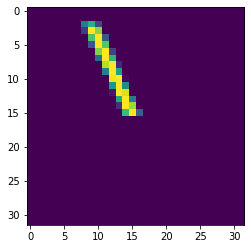

In [6]:
x = draw_line(2, 32, 32)
print(x.shape)
x = np.squeeze(x)
x.shape
from matplotlib import pyplot as plt
plt.imshow(x, interpolation='nearest')
plt.show()

In [7]:
def creat_dataset(num_data):
  dataset = np.zeros((num_data,32,32))
  for i in range(num_data):
    angle = 2 * random.random() * math.pi
    m = draw_line(angle, 32, 32)
    m = np.squeeze(m)
    dataset[i] = m
  return dataset
n_dataset = 5000
dataset_train = creat_dataset(n_dataset)
print(dataset_train.shape)

(5000, 32, 32)


In [8]:
from google.colab import drive
#mount google drive
drive.mount('/content/drive')
path = "/content/lines32/lines32_data5000"
os.chdir(path)
os.listdir(path)
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import imageio
import skimage.io as io
for i in range(n_dataset):
  im = dataset_train[i]
  im = np.array(im)
  imageio.imwrite(np.str(i)+'.jpg',im) #save
  #io.imsave(content/sample_data/lines32+np.str(i)+'.jpg',im)

im = dataset_train[1]
print(im.shape)
im = np.array(im)
#print(im)

#creat grey scale image
#imageio.imwrite('im.jpg', im)


from matplotlib import pyplot as plt
plt.imshow(im, interpolation='nearest')
plt.show()

In [10]:
import time
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch import nn, optim
import torch.nn.functional as F

#from python_utils.import_ import import_global
#import_global('show_array') 
#from python_utils import show_array
#from python_utils import mosaic
#from show_array import *
#from mosaic import *
import sklearn
print(sklearn.__version__)
!apt update -qq
!apt install -qq cmake ffmpeg
#!pip install dlib

![[ ! -e utils ]] && \
  git clone https://github.com/kylemcdonald/python-utils -b show_array utils


0.22.2.post1
60 packages can be upgraded. Run 'apt list --upgradable' to see them.
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 60 not upgraded.
Cloning into 'utils'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 258 (delta 3), reused 7 (delta 3), pack-reused 248
Receiving objects: 100% (258/258), 55.68 KiB | 640.00 KiB/s, done.
Resolving deltas: 100% (143/143), done.
Note: checking out 'a4fd6c2f5275ae6b836f7d01caf42cf46a0af782'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing anothe

In [11]:

import os
from google.colab import drive
#mount google drive
drive.mount('/content/drive')
path = "/content/lines32"

print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/lines32/lines32_data5000


In [12]:
#define class Dataset
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torch.optim as optim
import os
import torch.utils.data as data
root ='/content/lines32/'#调用图像
def default_loader(path):
    return Image.open(path).convert('L')
 
class MyTrainData(torch.utils.data.Dataset):
  def __init__(self, txt, transform=None,target_transform=None, loader=default_loader):
    super(MyTrainData,self).__init__()
    fh = open(txt, 'r')
    imgs = []
    for line in fh:
      line = line.strip('\n')
      line = line.rstrip('\n')
      words = line.split()
      imgs.append((words[0]))
    self.imgs = imgs
    self.transform = transform
    self.target_transform = target_transform
    self.loader = loader

  def __getitem__(self, index):
    fn = self.imgs[index]
    img = self.loader(fn)
    if self.transform is not None:
      img = self.transform(img)
    return img

 
  def __len__(self):
    return len(self.imgs) #这个是必须返回的长度

In [ ]:
#write txt file for dataset
import os
dir = '/content/lines32/lines32_data5000' + '/'
files = os.listdir(dir)
files.sort()
train = open('/content/lines32/train.txt','a')
val = open('/content/lines32/val.txt', 'a')
i = 1
for file in files:
  if i<4994:
    fileType = os.path.split(file)
    if fileType[1] == '.txt':
      continue
    name =  str(dir) +  file + '\n'
    train.write(name)
    i = i+1
    print(i)
  else:
    fileType = os.path.split(file)
    if fileType[1] == '.txt':
      continue
    name = str(dir) +file + '\n'
    val.write(name)
    i = i+1
    print(i)
val.close()
train.close()

In [14]:
# Root directory for dataset
#dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

num_of_trainData: 4992
num_of_testData: 8


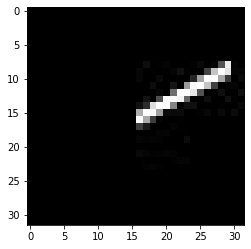

In [15]:
train_data=MyTrainData(txt=root+'train.txt', transform=transforms.ToTensor())
test_data = MyTrainData(txt=root+'val.txt', transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_data, batch_size = batch_size, shuffle=True,num_workers=2)
test_loader = DataLoader(dataset=test_data, batch_size = batch_size, shuffle=False,num_workers=2)
print('num_of_trainData:', len(train_data))
print('num_of_testData:', len(test_data))

import torchvision
img = torchvision.utils.make_grid(train_data[1]).numpy()
plt.imshow(np.transpose(img,(1,2,0)))
plt.show()

0 torch.Size([64, 1, 32, 32])


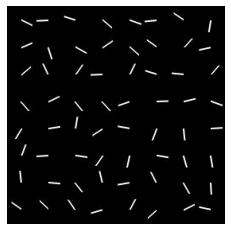

In [16]:
#show one batch
def show_batch(sample_batched):
  images_batch = sample_batched
  batch_size = len(images_batch)
  im_size = images_batch.size(2)
  grid = utils.make_grid(images_batch)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

 
  
for i_batch, sample_batched in enumerate(train_loader):
  print(i_batch, sample_batched.size())
  if i_batch == 0:
    plt.figure()
    show_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    break


dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [25]:
from utils.show_array import *
from utils.mosaic import *

In [31]:
args = {
    'epochs': 300,
    'width': 32,
    'latent_width': 4,
    'depth': 16,
    'advdepth': 16,
    'advweight': 0.5,
    'reg': 0.2,
    'latent': 2,
    'colors': 1,
    'lr': 0.0001,
    'batch_size': 64,
    'device': 'cuda'
}

def build_batches(x, n):
    x = np.asarray(x)
    m = (x.shape[0] // n) * n
    return x[:m].reshape(-1, n, *x.shape[1:])

In [32]:
def swap_halves(x):
    a, b = x.split(x.shape[0]//2)
    return torch.cat([b, a])

# torch.lerp only support scalar weight
def lerp(start, end, weights):
    return start + weights * (end - start)

def L2(x):
    return torch.mean(x**2)

In [33]:
activation = nn.LeakyReLU
import math
# authors use this initializer, but it doesn't seem essential
def Initializer(layers, slope=0.2):
    for layer in layers:
        if hasattr(layer, 'weight'):
            w = layer.weight.data
            std = 1/np.sqrt((1 + slope**2) * np.prod(w.shape[:-1]))
            w.normal_(std=std)  
        if hasattr(layer, 'bias'):
            layer.bias.data.zero_()

def Encoder(scales, depth, latent, colors):
    layers = []
    layers.append(nn.Conv2d(colors, depth, 1, padding=1))
    kp = depth
    for scale in range(scales):
        k = depth << scale
        layers.extend([nn.Conv2d(kp, k, 3, padding=1), activation()])
        layers.extend([nn.Conv2d(k, k, 3, padding=1), activation()])
        layers.append(nn.AvgPool2d(2))
        kp = k
    k = depth << scales
    layers.extend([nn.Conv2d(kp, k, 3, padding=1), activation()])
    layers.append(nn.Conv2d(k, latent, 3, padding=1))
    Initializer(layers)
    return nn.Sequential(*layers)

def Decoder(scales, depth, latent, colors):
    layers = []
    kp = latent
    for scale in range(scales - 1, -1, -1):
        k = depth << scale
        layers.extend([nn.Conv2d(kp, k, 3, padding=1), activation()])
        layers.extend([nn.Conv2d(k, k, 3, padding=1), activation()])
        layers.append(nn.Upsample(scale_factor=2))
        kp = k
    layers.extend([nn.Conv2d(kp, depth, 3, padding=1), activation()])
    layers.append(nn.Conv2d(depth, colors, 3, padding=1))
    Initializer(layers)
    return nn.Sequential(*layers)

class Discriminator(nn.Module):
    def __init__(self, scales, depth, latent, colors):
        super().__init__()
        self.encoder = Encoder(scales, depth, latent, colors)
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape(x.shape[0], -1)
        x = torch.mean(x, -1)
        return x

scales = int(round(math.log(args['width'] // args['latent_width'], 2)))
encoder = Encoder(scales, args['depth'], args['latent'], args['colors']).to(args['device'])
decoder = Decoder(scales, args['depth'], args['latent'], args['colors']).to(args['device'])
discriminator = Discriminator(scales, args['advdepth'], args['latent'], args['colors']).to(args['device'])

opt_ae = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=args['lr'], weight_decay=1e-5)
opt_d = optim.Adam(discriminator.parameters(), lr=args['lr'], weight_decay=1e-5)

losses = defaultdict(list)

In [34]:
def reconstruct(x):
    out = decoder(encoder(x))
    return make_mosaic(out.cpu().data.numpy().squeeze())

def interpolate_2(x, side=8):
    z = encoder(x)
    z = z.data.cpu().numpy()

    a, b = z[:side], z[-side:]
    z_interp = [a * (1-t) + b * t for t in np.linspace(0,1,side-2)]
    z_interp = np.vstack(z_interp)
    x_interp = decoder(torch.FloatTensor(z_interp).to(args['device']))
    x_interp = x_interp.cpu().data.numpy()

    x_fixed = x.data.cpu().numpy()
    all = []
    all.extend(x_fixed[:side])
    all.extend(x_interp)
    all.extend(x_fixed[-side:])
    
    return make_mosaic(np.asarray(all).squeeze())

def interpolate_4(x, side=8):
    z = encoder(x)
    z = z.data.cpu().numpy()
    
    n = side*side
    xv, yv = np.meshgrid(np.linspace(0,1,side),
                         np.linspace(0,1,side))
    xv = xv.reshape(n,1,1,1)
    yv = yv.reshape(n,1,1,1)

    z_interp = \
        z[0] * (1-xv) * (1-yv) + \
        z[1] * xv * (1-yv) + \
        z[2] * (1-xv) * yv + \
        z[3] * xv * yv

    x_fixed = x.data.cpu().numpy()
    x_interp = decoder(torch.FloatTensor(z_interp).to(args['device']))
    x_interp = x_interp.data.cpu().numpy()
    x_interp[0] = x_fixed[0]
    x_interp[side-1] = x_fixed[1]
    x_interp[n-side] = x_fixed[2]
    x_interp[n-1] = x_fixed[3]
    
    return make_mosaic(x_interp.squeeze())
for i, data in enumerate(dataloader, 0):
  if i == 0:
    data_batches = data.cuda()
# random samples based on a reference distribution
def random_samples(x):
    z = encoder(data_batches)
    z = z.data.cpu().numpy()
    z_sample = np.random.normal(loc=z.mean(axis=0), scale=z.std(axis=0), size=z.shape)
    x_sample = decoder(torch.FloatTensor(z_sample).to(args['device']))
    x_sample = x_sample.data.cpu().numpy()
    return make_mosaic(x_sample.squeeze())

def status():
    x = data_batches
    chunks = [reconstruct(x), interpolate_2(x), interpolate_4(x), random_samples(x)]
    chunks = np.array([np.pad(e, (0,1), mode='constant', constant_values=255) for e in chunks])
    return make_mosaic(chunks)

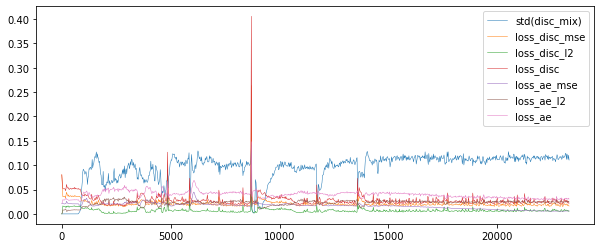

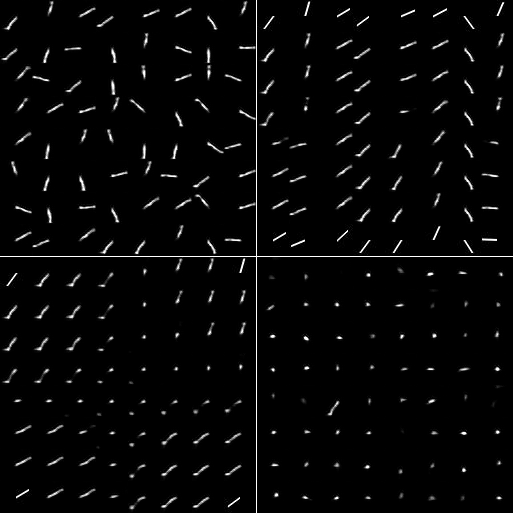

299/300; 1326.03 samples/sec


In [35]:
it = 0
start_time = time.time()

try:
    for epoch in range(args['epochs']):
        for i, data in enumerate(dataloader, 0):
            data = data.cuda()
            z = encoder(data)
            out = decoder(z)
            disc = discriminator(torch.lerp(out, data, args['reg']))
        
            alpha = torch.rand(args['batch_size'], 1, 1, 1).to(args['device']) / 2
            z_mix = lerp(z, swap_halves(z), alpha)
            out_mix = decoder(z_mix)
            disc_mix = discriminator(out_mix)

            loss_ae_mse = F.mse_loss(out, data)
            loss_ae_l2 = L2(disc_mix) * args['advweight']
            loss_ae = loss_ae_mse + loss_ae_l2
            
            opt_ae.zero_grad()
            loss_ae.backward(retain_graph=True)
            
            
            loss_disc_mse = F.mse_loss(disc_mix, alpha.reshape(-1))
            loss_disc_l2 = L2(disc)
            loss_disc = loss_disc_mse + loss_disc_l2
            
            opt_d.zero_grad()
            loss_disc.backward()
            #RuntimeError inplace
            opt_ae.step()
            opt_d.step()

            losses['std(disc_mix)'].append(torch.std(disc_mix).item())
            losses['loss_disc_mse'].append(loss_disc_mse.item())
            losses['loss_disc_l2'].append(loss_disc_l2.item())
            losses['loss_disc'].append(loss_disc.item())
            losses['loss_ae_mse'].append(loss_ae_mse.item())
            losses['loss_ae_l2'].append(loss_ae_l2.item())
            losses['loss_ae'].append(loss_ae.item())

            if it % 100 == 0:
                img = status()
                
                plt.figure(facecolor='w', figsize=(10,4))
                for key in losses:
                    total = len(losses[key])
                    skip = 1 + (total // 1000)
                    y = build_batches(losses[key], skip).mean(axis=-1)
                    x = np.linspace(0, total, len(y))
                    plt.plot(x, y, label=key, lw=0.5)
                plt.legend(loc='upper right')
                
                clear_output(wait=True)
                plt.show()
                show_array(img * 255)
                
                speed = args['batch_size'] * it / (time.time() - start_time)
                print(f'{epoch+1}/{args["epochs"]}; {speed:.2f} samples/sec')

            it += 1
except KeyboardInterrupt:
    pass

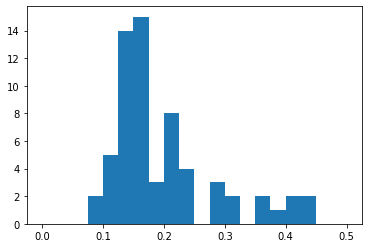

tensor([0.2070, 0.1105, 0.1417, 0.1739, 0.1952, 0.1674, 0.1875, 0.4303, 0.1500,
        0.1306, 0.2495, 0.1566, 0.1704, 0.2184, 0.1058, 0.1543, 0.1241, 0.1366,
        0.4208, 0.1619, 0.1738, 0.3078, 0.1746, 0.2174, 0.2189, 0.2002, 0.4015,
        0.0855, 0.4335, 0.2921, 0.1544, 0.1264, 0.1426, 0.1411, 0.1405, 0.2270,
        0.1650, 0.1233, 0.2335, 0.1561, 0.1780, 0.0968, 0.1377, 0.1708, 0.6003,
        0.1620, 0.1309, 0.1206, 0.1589, 0.3561, 0.3849, 0.1450, 0.2087, 0.3658,
        0.2890, 0.3130, 0.1415, 0.2070, 0.2896, 0.2438, 0.1411, 0.2201, 0.1415,
        0.1528], device='cuda:0', grad_fn=<MeanBackward1>)


In [40]:
plt.hist(disc_mix.data.cpu().numpy(), range=[0,0.5], bins=20)
plt.show()
print(disc_mix)

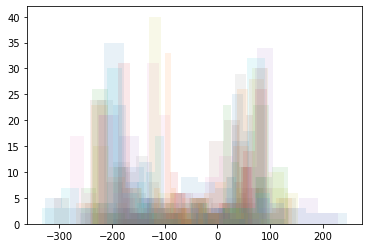

In [39]:
z = encoder(data_batches)
z = z.data.cpu().numpy().reshape(len(z), -1).T
for dim in z:
    plt.hist(dim, bins=12, alpha=0.1)
plt.show()